In [1]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.metrics import jaccard_score,  accuracy_score, f1_score, make_scorer, mean_absolute_error
import random
from patchify import patchify, unpatchify

In [2]:
SIZE_X = 256
SIZE_Y = 256

In [3]:
train_images = []
for directory_path in glob.glob("/Users/anshugusain/tf-nuclei/content/60000X/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = np.asarray(image.load_img(img_path,0), dtype = np.float64)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
        
train_images = np.array(train_images)/255

In [4]:
train_masks = [] 
for directory_path in glob.glob("/Users/anshugusain/tf-nuclei/content/60000Y/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
                  
train_masks = np.array(train_masks)
train_masks = train_masks/(train_masks.max())

In [5]:
train_masks.dtype

dtype('float64')

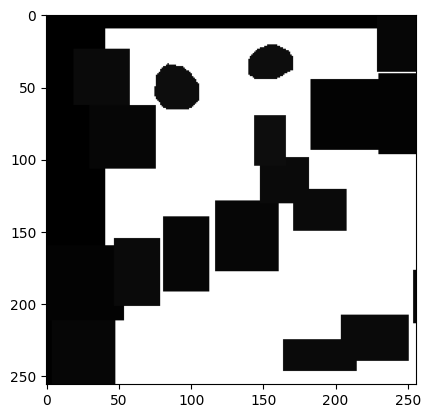

In [6]:
plt.imshow(train_masks[2],cmap='gray')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train_images,train_masks>.9 ,random_state=42, test_size=0.20)

In [8]:
np.unique(y_train)

array([False,  True])

In [9]:
y_train.dtype

dtype('bool')

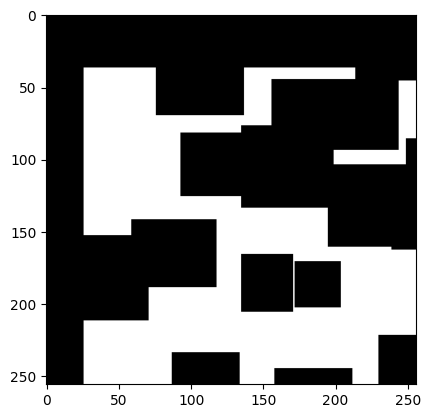

In [10]:
plt.imshow(y_train[0],cmap='gray')

In [11]:
y_train.dtype

dtype('bool')

In [12]:
#Building the model
 
inputs = tf.keras.layers.Input((256, 256, 3))
s = inputs #converts integers from input layers into floating points

#Contraction Path
                           # feature space  
                           # \/
c1 = tf.keras.layers.Conv2D(16,(3,3), activation = "relu", kernel_initializer='he_normal', padding = 'same')(s)#kernel initializer is the initial weights used by the neural network (he_normal is a trunkated normal distribution centered on 0)
c1 = tf.keras.layers.Dropout(.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3), activation = "relu", kernel_initializer="he_normal", padding = "same")(c1 ) #Padding ensures that the output image has the same dimensions as the input image
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1) #First maxpooling layer puts the values into a 2x2 matrix, and gets the maximum values

c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
c2 = tf.keras.layers.Dropout(.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
p2=tf.keras.layers.MaxPooling2D((2,2))(c2)

c3= tf.keras.layers.Conv2D(64, (3,3), activation = "relu", kernel_initializer="he_normal", padding="same")(p2)
c3 = tf.keras.layers.Dropout(.2)(c3)
c3=tf.keras.layers.Conv2D(64,(3,3), activation = "relu", kernel_initializer="he_normal", padding="same")(c3)
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)

c4= tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
c4= tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3),activation="relu", kernel_initializer="he_normal", padding="same")(c4)
p4=tf.keras.layers.MaxPooling2D((2,2))(c4)

c5=tf.keras.layers.Conv2D(256, (3,3), activation ="relu", kernel_initializer="he_normal", padding="same")(p4)
c5=tf.keras.layers.Dropout(0.3)(c5)
c5=tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

#Expansive Patch
u6= tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
u6= tf.keras.layers.concatenate([u6,c4])#Concatenates layers u6 and c4 as shown in the Unet architecture
c6=tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer='he_normal', padding="same")(u6)
c6=tf.keras.layers.Dropout(0.2)(c6)
c6=tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7=tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7=tf.keras.layers.concatenate([u7,c3])
c7=tf.keras.layers.Conv2D(64,(3,3), activation="relu",kernel_initializer="he_normal", padding="same")(u7)
c7=tf.keras.layers.Dropout(0.2)(c7)
c7=tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

u8=tf.keras.layers.Conv2DTranspose(32, (2,2),strides=(2,2), padding="same")(c7)
u8=tf.keras.layers.concatenate([u8, c2])
c8=tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
c8=tf.keras.layers.Dropout(0.1)(c8)
c8=tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9=tf.keras.layers.concatenate([u9,c1])
c9=tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
c9=tf.keras.layers.Dropout(0.1)(c9)
c9=tf.keras.layers.Conv2D(16,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)\


outputs=tf.keras.layers.Conv2D(1, (1,1), activation="sigmoid")(c9)
model=tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Metal device set to: Apple M2 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-05-27 22:12:08.838611: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-27 22:12:08.838989: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [13]:
results = model.fit(X_train.squeeze(), y_train.squeeze(), batch_size=1, epochs=5, verbose =0)

2023-05-27 22:12:10.794566: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-27 22:12:11.383563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

In [ ]:
model = tf.keras.models.load_model('publicModel.h5')

In [ ]:
def average_calc(X_test, y_test):
  IoUs = [len(X_test)]
  total =0
  average =0
  
  for i in range(0,len(X_test)):
    test_predict = model.predict(np.expand_dims(X_test[i],0),verbose =0)
    test_predict = np.asarray(test_predict) 
    IoU = jaccard_score((test_predict>.3).squeeze(), y_test[i].squeeze(), average='micro')
    total =IoU + total

  average = total / len(X_test)
  return average


In [ ]:
average_calc(X_test, y_test)

2023-05-26 09:02:20.861211: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-26 09:02:20.954451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7018774122822358

1/1 [==============================] - 0s 15ms/step


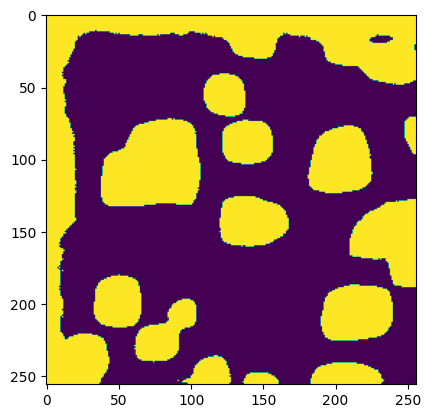

In [ ]:
inum = random.randrange(0,len(X_test))
test_predict = model.predict(np.expand_dims(X_test[inum],0))
test_predict = np.asarray(test_predict)
plt.imshow(np.logical_not(test_predict.squeeze()>.5))

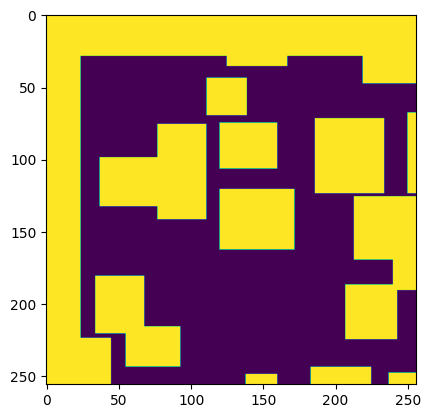

In [ ]:
plt.imshow(np.logical_not(y_test[inum]))

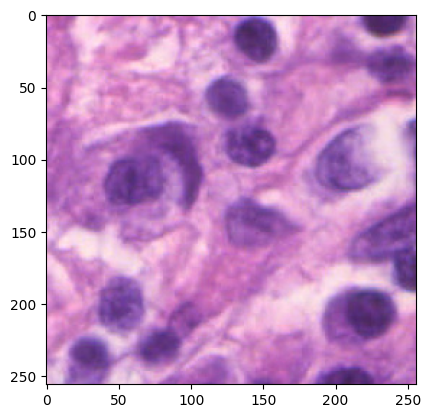

In [ ]:
plt.imshow(X_test[inum])

In [ ]:
IoU = jaccard_score((test_predict>.3).squeeze(), y_test[inum].squeeze(), average='micro')
IoU

0.662919963012432

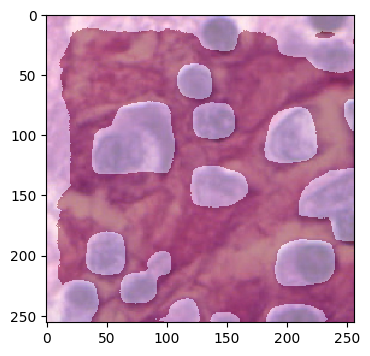

In [58]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
mask = test_predict.squeeze()>.5
im = X_test[inum]
masked = np.ma.masked_where(mask == 0, mask)
plt.figure()
#plt.subplot(1, 2, 1)
#plt.imshow(im, 'gray', interpolation='none')
plt.subplot(1, 2, 2)
plt.imshow(im, 'gray', interpolation='none', alpha = 1)
plt.imshow(mask,"Reds", interpolation='none', alpha=.4)
plt.show()

In [69]:
pX=[]
yy=[]

for a in range(1,6):
  Xpath = '/Users/anshugusain/tf-nuclei/content/Field-00' + str(a) + '.png'
  Ximg = tf.keras.preprocessing.image.load_img(Xpath)
  ypath = '/Users/anshugusain/tf-nuclei/content/Field-00' + str(a) + '-mask-STARDIST.tif'
  yimg = tf.keras.preprocessing.image.load_img(ypath)

  Ximg = np.asarray(Ximg)
  Xpatches = patchify(Ximg,(256,256,3), step=256)
  yimg = np.asarray(yimg)   
  ypatches = patchify(yimg, (256,256,1), step=256)

  for m in range (0,Xpatches.shape[0]):
    for l in range(0,Xpatches.shape[1]):
       yy.append(ypatches[m,l,0])
       pX.append(Xpatches[m, l,0])

pX = np.array(pX)
yy = np.array(yy)

pX = (pX/pX.max())
yy = (yy/yy.max())

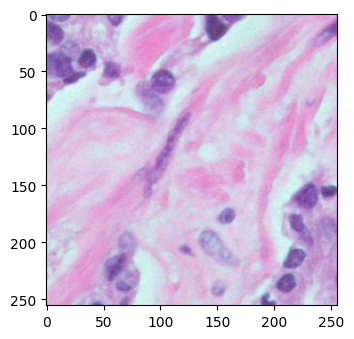

In [70]:
plt.imshow(pX[4])

1/1 [==============================] - 0s 16ms/step


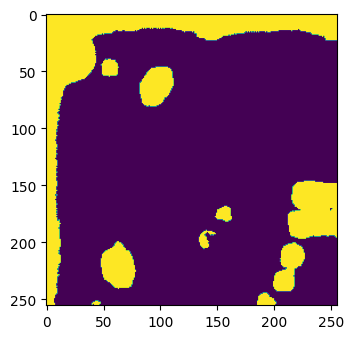

In [71]:
test_predct = model.predict(np.expand_dims(pX[4],0))
plt.imshow(np.logical_not(test_predct.squeeze()>.5))

In [72]:
model.save('publicModel.h5')

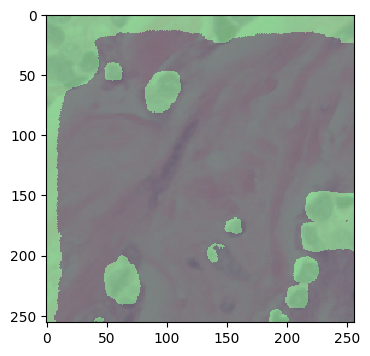

In [76]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
mask = np.logical_not(test_predct.squeeze()>.5)
im = pX[4]
masked = np.logical_not(test_predct.squeeze()>.5)
plt.figure()
#plt.subplot(1, 2, 1)
#plt.imshow(im, 'gray', interpolation='none')
plt.subplot(1, 2, 2)
plt.imshow(im, 'gray', interpolation='none', alpha = 1)
plt.imshow(mask,"Accent_r", interpolation='none', alpha=.8)
plt.show()